# Importação de biblioteca e construção do DataFrame de caminhos


In [ ]:
import pandas as pd
edges = pd.read_csv('musae_facebook_edges.csv',sep=',',encoding ='UTF-8',header = 0)
edges


,id_1,id_2
0,0,18427
1,1,21708
2,1,22208
3,1,22171
4,1,6829
...,...,...
170997,20188,20188
170998,22340,22383
170999,22348,22348
171000,5563,5563


# Construção DataFrame de informações

In [ ]:
target = pd.read_csv('musae_facebook_target.csv',sep=',',encoding ='UTF-8',header = 0)
target

,id,facebook_id,page_name,page_type
0,0,145647315578475,The Voice of China 中国好声音,tvshow
1,1,191483281412,U.S. Consulate General Mumbai,government
2,2,144761358898518,ESET,company
3,3,568700043198473,Consulate General of Switzerland in Montreal,government
4,4,1408935539376139,Mark Bailey MP - Labor for Miller,politician
...,...,...,...,...
22465,22465,1379955382222841,Kurt Wiegel MdL,politician
22466,22466,1651527995097082,dubdub Stories,company
22467,22467,155369444540412,Ministerio del Interior - Paraguay,government
22468,22468,175067819212798,Tottus Perú,company


In [ ]:
# set dos dicionarios

# dicionario de pesos (os pesos foram definidos com base em relações das 4 categorias {company, tvshow, government, politician})
dictionary_of_weight = {"company":{"company": 1, "tvshow": 2, "government": 3, "politician": 4}, "government":{"government": 1, "tvshow": 4, "company": 3, "politician": 2}, "tvshow":{"tvshow": 1, "company": 2, "government": 3, "politician": 4}, "politician":{"politician": 1, "company": 3, "government": 2, "tvshow": 4}}
# dicionario de nome/id
dictionary_of_names = {}
for line in range(len(target)):
    dictionary_of_names[target.iloc[line]["id"]] = target.iloc[line]["page_name"]


# dicionario do grafo(edges)
dictionary_of_edges = {}
for line in range(len(edges)):
    id_1 = edges.iloc[line]["id_1"]
    id_2 = edges.iloc[line]["id_2"]
    if id_1 not in dictionary_of_edges.keys():
        dictionary_of_edges[id_1] = {}
    cost = {id_2 : dictionary_of_weight[target.iloc[id_1]["page_type"]][target.iloc[id_2]["page_type"]]}
    dictionary_of_edges[id_1].update(cost)


Menor custo entre Governo de Pernambuco e MasterChef Portugal é: 7.
Menor distancia entre Governo de Pernambuco e MasterChef Portugal é: ['Governo de Pernambuco', 'Ministério do Turismo', 'Secretaria Nacional de Aviação Civil', 'TAP Air Portugal', 'MasterChef Portugal'].



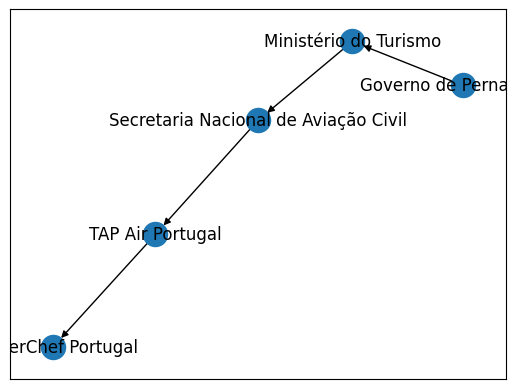

In [ ]:
import sys
import networkx as nx
import matplotlib.pyplot as plt
class min_heap:
    def __init__(self, arr):
        self.heap = arr
        if len(self.heap) == 0:
            pass
        else:
            self.build_min_heap()

    def min_heapify(self, index):
        left_child = self.left(index)
        right_child = self.right(index)
        if left_child < len(self.heap) and self.heap[left_child][1] < self.heap[index][1]:
            smallest = left_child
        else:
            smallest = index
        if right_child < len(self.heap) and self.heap[right_child][1] < self.heap[smallest][1]:
            smallest = right_child
        if smallest != index:
            self.heap[index], self.heap[smallest] = self.heap[smallest], self.heap[index]
            self.min_heapify(smallest)

    def build_min_heap(self):
        for index in range(len(self.heap) // 2 - 1, -1, -1):
            self.min_heapify(index)

    def lowest_element(self):
        if len(self.heap) == 0:
            return None
        popped = self.heap.pop(0)
        return popped[0]

    def left(self, index):
        return 2 * index + 1

    def right(self, index):
        return 2 * index + 2

    def parent(self, index):
        return index // 2

def dijkstra(graph, initial, final):
    infinito = sys.maxsize  # valor inifinito, custo inicial de cada vertice sem ser o inicial
    path = {}

    for i in range(len(target)):  # criação de um dicionario com o custo de cada vertice e o menor caminho (antecessores)
        path[i] = {"cost": infinito, "pred": []}

    path[initial]["cost"] = 0  # custo zero no vertice inicial
    visited = []  # lista de visitados
    actual = initial  # vertice atual

    def relaxing(cost, vertex, actual):  # função de relaxamento
        path[vertex]["cost"] = cost
        path[vertex]["pred"] = path[actual]["pred"] + list([dictionary_of_names[actual]])

    for i in range(len(graph)):
        if actual not in visited: # caso o vertice atual não tenha sido visitado, ele será visitado e seu adjacente com menor custo será visitado
            visited.append(actual)
            min_heap_arr = []
            if actual in graph.keys():
                for vertex in graph[actual]: # vertice adjacente
                    if vertex not in visited:
                        cost = path[actual]["cost"] + graph[actual][vertex]
                        if cost < path[vertex]["cost"]: # caso o custo do caminho para esse vertice seja menor que o caminho atual, relaxamento será feito
                            relaxing(cost, vertex, actual) # relaxamento
                    min_heap_arr.append([vertex, cost]) 

        heapify = min_heap(min_heap_arr) # realiza o heap de minimo dos vertices adjacentes
        lowest_adjacent = heapify.lowest_element()
        actual = lowest_adjacent # vertice visitado será o com menor custo
        if actual is None: # caso não tenha vertices adjacentes, voltará para os adjacentes ainda não visitados dos vertices anteriores
            stop = False
            for i in range(len(visited)//2, -1 , -1): # faz um bubble down na lista de visitados, e nesses vertices visitados, verifica entre os adjacentes deles se ainda existe algum que não foi visitado
                if stop is True: # foi feito len(visited)//2 para diminuir o tempo de execução para a maioria dos caminhos, pois são mais de 170 mil caminhos possiveis!
                    break
                if visited[i] in dictionary_of_edges.keys(): 
                    for j in dictionary_of_edges[visited[i]]: # verifica se existe algum vertice adjacente não visitado, caso exista: visita ele
                        if j not in visited:
                            actual = j
                            stop = True
                            break


    name_initial = dictionary_of_names[initial]
    name_final = dictionary_of_names[final]
    if path[final]['cost'] == infinito:
        print(f"Não há como chegar de {name_initial} até {name_final}. ")
    else:
        print(f"Menor custo entre {name_initial} e {name_final} é: {path[final]['cost']}.")
        print(f"Menor distancia entre {name_initial} e {name_final} é: {path[final]['pred'] + list([name_final])}.\n")
        return path[final]['pred'] + list([name_final])

def visualize(g):
        G = nx.DiGraph()
        G.add_edges_from(g)
        nx.draw_networkx(G)
        plt.show()

g = dijkstra(dictionary_of_edges, 572, 15772)
visual = []
for i in range(len(g) -1):
    visual.append([g[i], g[i+1]])
visualize(visual)